# TODO: I'm reporting on token level. Report on concept level and try handle concepts tagged as NA

In [1]:
import pandas as pd
import random 
import os

In [2]:
DATA_DIR = "/Users/chenkx/git/clinical-negation/emnlp2017-bilstm-cnn-crf/data/i2b2_2010/real/test.txt"

In [3]:
def to_df(data_dir, column_names=None, trim_col=[]):
    with open(data_dir, "r") as f:
        lines = f.readlines()
        lines = [line.split('\t') for line in lines]
    if not column_names:
        column_names = ['token', 'begin', 'end', 'section', 'filename', 'concept', 'label']
    df = pd.DataFrame(lines, columns = column_names)
#     if trim_col:
#         for col in trim_col:
#             df[col] = df[col].str.rstrip("\n")
    col = df.columns[-1]
    df[col] = df[col].str.rstrip("\n")
    return df

## Section analysis

In [76]:
stat = raw.loc[raw.concept=="B"].groupby("section")["label"].value_counts(normalize=True).reset_index(name='proportion')
stat.loc[stat.groupby('section')["proportion"].idxmax()]

,section,label,proportion
0,Addendum,present,0.589744
4,Advance directive/Code,present,1.000000
5,Allergies,absent,0.688073
8,Assessment,present,0.767355
13,Assessment/Plan,present,0.555276
17,Chief complaint,present,0.956989
20,Complications,present,0.666667
22,Consultations,present,0.760870
25,Diagnoses,present,0.926718
30,Family history,associated_with_someone_else,0.929825


# downsample dataset for fair comparison

## Load results

In [4]:
models = [m[:-4] for m in os.listdir("/Users/chenkx/git/clinical-negation/emnlp2017-bilstm-cnn-crf/results/predictions") if m.endswith(".txt")]
models.sort()
models

['base-adam',
 'downsample-base',
 'downsample-lowly-negated-base-adam',
 'downsample-lowly-negated-with-section-adam',
 'downsample-with-section',
 'highly-negated-base-adam',
 'highly-negated-with-section-adam',
 'lowly-negated-base-adam',
 'lowly-negated-with-section-adam',
 'section-adam']

In [5]:
dfs = {}
for m in models:
    if m in ["base-adam", "section-adam"]:
        continue
    df = to_df(os.path.join("/Users/chenkx/git/clinical-negation/emnlp2017-bilstm-cnn-crf/results/predictions/",m+".txt"),
              column_names=["tokens","pred","label"])
    dfs[m] = df

In [6]:
dfs.keys()

dict_keys(['downsample-base', 'downsample-lowly-negated-base-adam', 'downsample-lowly-negated-with-section-adam', 'downsample-with-section', 'highly-negated-base-adam', 'highly-negated-with-section-adam', 'lowly-negated-base-adam', 'lowly-negated-with-section-adam'])

## Load raw data

In [7]:
raw = to_df(DATA_DIR)
raw["row_id"] = raw.index.to_list()
raw.section = raw.section.fillna(method="ffill")
# raw.insert(0,"row_id", raw.index.to_list())
raw

,token,begin,end,section,filename,concept,label,row_id
0,The,0,3,Unknown/Unclassified,0003.txt,O,N/A,0
1,patient,4,11,Unknown/Unclassified,0003.txt,O,N/A,1
2,is,12,14,Unknown/Unclassified,0003.txt,O,N/A,2
3,a,15,16,Unknown/Unclassified,0003.txt,O,N/A,3
4,**AGE,17,22,Unknown/Unclassified,0003.txt,O,N/A,4
...,...,...,...,...,...,...,...,...
441945,10/08/01,7945,7953,Complications,0476.txt,O,N/A,441945
441946,T,7954,7955,Complications,0476.txt,O,N/A,441946
441947,:,7956,7957,Complications,0476.txt,O,N/A,441947
441948,10/08/01,7958,7966,Complications,0476.txt,O,N/A,441948


## Analyze Results

In [157]:
def compute_acc(df, col_label, col_pred, default=None):
    """
    default: If a concept is classified as "N/A", label it using the default value instead
    'absent', 'possible', 'hypothetical', 'conditional', 'associated_with_someone_else'
    """
    def get_first_most_common(series):
        modes = series.mode()
        if len(modes) == 1 or modes[0] != "N/A":
            return modes[0]
        return modes[1]
    
    df = df[df.token != "\n"]
    tagged_non_concept = sum((df.concept == "O") & (df[col_pred] != "N/A"))
    len_non_concept_tokens = sum(df.concept == "O")
    assert all(~df.concept.isna())
    df = df[(df["concept"] != "O")]

    print(col_pred)

    # token level 
    # assign each concept a concept_id and use mode
    df["concept_id"] = (df.concept=="B").cumsum() - 1
    pred = df.groupby("concept_id")[col_pred].transform(get_first_most_common)
    df[col_pred] = pred
    
    print("Percentage of tagging concept as N/A: %d/%d=%.04f" % 
          (sum(pred == "N/A"), 
           len(df), 
           sum(pred == "N/A") / len(df)))
    print("Percentage of tagging non-concept: %d/%d=%.04f" % 
          (tagged_non_concept, 
           len_non_concept_tokens, 
           tagged_non_concept / len_non_concept_tokens))
    
 
#    print("Token-level Accracy (after converting converting N/A concepts to %s): %.4f(%d/%d)" % 
#           (default,
#            sum(df[col_label]==pred)/len(df), 
#            sum(df[col_label]==pred),
#            len(df)))
    
    # concept level 
    df2 = df[df.concept == "B"]
    print("Concept-level accuracy (NOT relabeling NA concepts): %d/%d=%.04f" % 
          (sum(df2[col_pred] == df2["label"]), 
           len(df2), 
           sum(df2[col_pred] == df2["label"]) / len(df2)))
    
    # use the default val to label any unclassified concept 
#     pred = df[col_pred]
    if default and default != "":
        pred[pred == "N/A"] = default

    print("Concept-level Percentage of tagging concept as N/A: %d/%d=%.04f" % 
          (sum(df2[col_pred] == "N/A"), 
           len(df2), 
           sum(df2[col_pred] == "N/A") / len(df2)))
    print("Concept-level Accracy (after converting converting N/A concepts to %s): %.4f(%d/%d)" % 
          (default,
           sum(df2[col_label]==pred[df.concept=="B"])/len(df2), 
           sum(df2[col_label]==pred[df.concept=="B"]),
           len(df2)))


    return [sum(df[col_label]==pred)/sum(~df.concept.isna()), 
            sum(df[col_label]==pred),
            len(df)]

## Smaller size

### Result of highly negated set

In [8]:
result_high = dfs["highly-negated-base-adam"][["tokens"]]
result_high["highly-negated-base-adam"] = dfs["highly-negated-base-adam"].pred
result_high["highly-negated-with-section-adam"] = dfs["highly-negated-with-section-adam"].pred

<ipython-input-8-62fc39aad798>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_high["highly-negated-base-adam"] = dfs["highly-negated-base-adam"].pred


In [9]:
highly_negated = to_df( "/Users/chenkx/git/clinical-negation/emnlp2017-bilstm-cnn-crf/data/i2b2_2010_highly_negated/test.txt",
                      column_names = ['token', 'begin', 'end', 'section', 'filename', 'concept', 'label', "row_id"])
highly_negated = highly_negated[["row_id","token","begin","concept","section","label"]]

In [10]:
result_high = pd.concat([highly_negated, result_high.drop("tokens", axis=1)],axis=1)
result_high

,row_id,token,begin,concept,section,label,highly-negated-base-adam,highly-negated-with-section-adam
0,2811,:,2019,O,Allergies,N/A,N/A,N/A
1,2812,BACTRIM,2021,O,Allergies,N/A,absent,absent
2,2813,.,2029,O,Allergies,N/A,N/A,N/A
3,None,\n,None,None,None,None,None,None
4,2815,MEDICATIONS,2031,O,Allergies,N/A,N/A,N/A
...,...,...,...,...,...,...,...,...
36314,441944,:,7943,O,Complications,N/A,N/A,N/A
36315,441945,10/08/01,7945,O,Complications,N/A,N/A,N/A
36316,441946,T,7954,O,Complications,N/A,N/A,N/A
36317,441947,:,7956,O,Complications,N/A,N/A,N/A


In [32]:
raw.label.unique()

array(['N/A', 'present', None, 'absent', 'possible', 'hypothetical',
       'conditional', 'associated_with_someone_else'], dtype=object)

In [159]:
print("highly-negated-base-adam:")
compute_acc(result_high, "label", "highly-negated-base-adam")

highly-negated-base-adam:
highly-negated-base-adam
Percentage of tagging concept as N/A: 580/5285=0.1097
Percentage of tagging non-concept: 1590/28320=0.0561
Concept-level accuracy (NOT relabeling NA concepts): 1998/2411=0.8287
Concept-level Percentage of tagging concept as N/A: 215/2411=0.0892
Concept-level Accracy (after converting converting N/A concepts to None): 0.8287(1998/2411)


[0.8107852412488175, 4285, 5285]

In [160]:
print("highly-negated-base-adam:")
compute_acc(result_high, "label", "highly-negated-base-adam", "present")

highly-negated-base-adam:
highly-negated-base-adam
Percentage of tagging concept as N/A: 580/5285=0.1097
Percentage of tagging non-concept: 1590/28320=0.0561
Concept-level accuracy (NOT relabeling NA concepts): 1998/2411=0.8287
Concept-level Percentage of tagging concept as N/A: 215/2411=0.0892
Concept-level Accracy (after converting converting N/A concepts to present): 0.8880(2141/2411)


[0.8997161778618732, 4755, 5285]

In [161]:
print("highly-negated-base-adam:")
compute_acc(result_high, "label", "highly-negated-base-adam", "absent")

highly-negated-base-adam:
highly-negated-base-adam
Percentage of tagging concept as N/A: 580/5285=0.1097
Percentage of tagging non-concept: 1590/28320=0.0561
Concept-level accuracy (NOT relabeling NA concepts): 1998/2411=0.8287
Concept-level Percentage of tagging concept as N/A: 215/2411=0.0892
Concept-level Accracy (after converting converting N/A concepts to absent): 0.8544(2060/2411)


[0.8272469252601703, 4372, 5285]

In [172]:
print("highly-negated-with-section-adam:")
compute_acc(result_high, "label", "highly-negated-with-section-adam", "present")

highly-negated-with-section-adam:
highly-negated-with-section-adam
Percentage of tagging concept as N/A: 529/5285=0.1001
Percentage of tagging non-concept: 2160/28320=0.0763
Concept-level accuracy (NOT relabeling NA concepts): 2003/2411=0.8308
Concept-level Percentage of tagging concept as N/A: 214/2411=0.0888
Concept-level Accracy (after converting converting N/A concepts to present): 0.8864(2137/2411)


[0.9027436140018922, 4771, 5285]

In [173]:
print("highly-negated-with-section-adam:")
compute_acc(result_high, "label", "highly-negated-with-section-adam", "absent")

highly-negated-with-section-adam:
highly-negated-with-section-adam
Percentage of tagging concept as N/A: 529/5285=0.1001
Percentage of tagging non-concept: 2160/28320=0.0763
Concept-level accuracy (NOT relabeling NA concepts): 2003/2411=0.8308
Concept-level Percentage of tagging concept as N/A: 214/2411=0.0888
Concept-level Accracy (after converting converting N/A concepts to absent): 0.8586(2070/2411)


[0.8474929044465468, 4479, 5285]

In [186]:
result_high[result_high.concept.isin(["B", "I"])].groupby("section")["label"].value_counts(normalize=True)

section                      label       
Allergies                    absent          0.780392
                             conditional     0.180392
                             present         0.039216
Complications                present         0.833333
                             absent          0.166667
Physical examination/Status  present         0.624659
                             absent          0.339214
                             possible        0.029406
                             conditional     0.006511
                             hypothetical    0.000210
Review of systems            absent          0.657795
                             present         0.292776
                             possible        0.026616
                             conditional     0.022814
Name: label, dtype: float64

### Results of downsampled lowly negated set

In [16]:
result_down_negated = dfs["downsample-lowly-negated-base-adam"][["tokens"]]
result_down_negated["downsample-lowly-negated-with-section-adam"] = dfs["downsample-lowly-negated-with-section-adam"].pred
result_down_negated["downsample-lowly-negated-base-adam"] = dfs["downsample-lowly-negated-base-adam"].pred
len(result_down_negated)

<ipython-input-16-a138127fc576>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_down_negated["downsample-lowly-negated-with-section-adam"] = dfs["downsample-lowly-negated-with-section-adam"].pred


38824

In [17]:
down_negated = to_df( "/Users/chenkx/git/clinical-negation/emnlp2017-bilstm-cnn-crf/data/i2b2_2010_downsample-lowly_negated/test.txt",
                      column_names = ['token', 'begin', 'end', 'section', 'filename', 'concept', 'label', "row_id","to_keep"])
down_negated = down_negated[["row_id","token","begin","concept","section","label"]]
assert len(down_negated) == len(result_down_negated)

In [18]:
result_down_negated = pd.concat([down_negated, result_down_negated.drop("tokens", axis=1)],axis=1)

In [164]:
compute_acc(result_down_negated, "label", "downsample-lowly-negated-base-adam")

downsample-lowly-negated-base-adam
Percentage of tagging concept as N/A: 758/4022=0.1885
Percentage of tagging non-concept: 969/32088=0.0302
Concept-level accuracy (NOT relabeling NA concepts): 1107/1630=0.6791
Concept-level Percentage of tagging concept as N/A: 337/1630=0.2067
Concept-level Accracy (after converting converting N/A concepts to None): 0.6791(1107/1630)


[0.7031327697662855, 2828, 4022]

In [165]:
compute_acc(result_down_negated, "label", "downsample-lowly-negated-base-adam", "present")

downsample-lowly-negated-base-adam
Percentage of tagging concept as N/A: 758/4022=0.1885
Percentage of tagging non-concept: 969/32088=0.0302
Concept-level accuracy (NOT relabeling NA concepts): 1107/1630=0.6791
Concept-level Percentage of tagging concept as N/A: 337/1630=0.2067
Concept-level Accracy (after converting converting N/A concepts to present): 0.8393(1368/1630)


[0.8543013426156141, 3436, 4022]

In [187]:
compute_acc(result_down_negated, "label", "downsample-lowly-negated-with-section-adam", "absent")

downsample-lowly-negated-with-section-adam
Percentage of tagging concept as N/A: 665/4022=0.1653
Percentage of tagging non-concept: 871/32088=0.0271
Concept-level accuracy (NOT relabeling NA concepts): 1156/1630=0.7092
Concept-level Percentage of tagging concept as N/A: 276/1630=0.1693
Concept-level Accracy (after converting converting N/A concepts to absent): 0.7325(1194/1630)


[0.7332173048234709, 2949, 4022]

In [167]:
compute_acc(result_down_negated, "label", "downsample-lowly-negated-with-section-adam", "present")

downsample-lowly-negated-with-section-adam
Percentage of tagging concept as N/A: 665/4022=0.1653
Percentage of tagging non-concept: 871/32088=0.0271
Concept-level accuracy (NOT relabeling NA concepts): 1156/1630=0.7092
Concept-level Percentage of tagging concept as N/A: 276/1630=0.1693
Concept-level Accracy (after converting converting N/A concepts to present): 0.8417(1372/1630)


[0.8575335653903531, 3449, 4022]

### Results of downsampled test set

In [22]:
result_down = dfs["downsample-base"][["tokens"]]
result_down["downsample-with-section"] = dfs["downsample-with-section"].pred
result_down["downsample-base"] = dfs["downsample-base"].pred
len(result_down)

<ipython-input-22-1ed77da8a66c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_down["downsample-with-section"] = dfs["downsample-with-section"].pred


38899

In [23]:
down = to_df( "/Users/chenkx/git/clinical-negation/emnlp2017-bilstm-cnn-crf/data/i2b2_2010_downsample/test.txt",
                      column_names = ['token', 'begin', 'end', 'section', 'filename', 'concept', 'label', "row_id","to_keep"])
down = down[["row_id","token","begin","concept","section","label"]]
assert len(down) == len(result_down)

In [24]:
result_down = pd.concat([down, result_down.drop("tokens", axis=1)],axis=1)
result_down

,row_id,token,begin,concept,section,label,downsample-with-section,downsample-base
0,130,8.,598,O,Medications,N/A,N/A,N/A
1,None,\n,None,None,None,None,None,None
2,162,Zithromax,726,O,Medications,N/A,N/A,N/A
3,163,will,736,O,Medications,N/A,N/A,N/A
4,164,continue,741,O,Medications,N/A,N/A,N/A
...,...,...,...,...,...,...,...,...
38894,441881,clinic,7612,O,Follow-up/Instructions,N/A,N/A,N/A
38895,441882,for,7619,O,Follow-up/Instructions,N/A,N/A,N/A
38896,441883,10/11/01,7623,O,Follow-up/Instructions,N/A,N/A,N/A
38897,441884,and,7632,O,Follow-up/Instructions,N/A,N/A,N/A


In [168]:
compute_acc(result_down, "label", "downsample-with-section", "present")
compute_acc(result_down, "label", "downsample-with-section", "absent")
compute_acc(result_down, "label", "downsample-base", "present")
compute_acc(result_down, "label", "downsample-base", "absent")

downsample-with-section
Percentage of tagging concept as N/A: 441/4033=0.1093
Percentage of tagging non-concept: 1386/32152=0.0431
Concept-level accuracy (NOT relabeling NA concepts): 1243/1634=0.7607
Concept-level Percentage of tagging concept as N/A: 174/1634=0.1065
Concept-level Accracy (after converting converting N/A concepts to present): 0.8427(1377/1634)
downsample-with-section
Percentage of tagging concept as N/A: 441/4033=0.1093
Percentage of tagging non-concept: 1386/32152=0.0431
Concept-level accuracy (NOT relabeling NA concepts): 1243/1634=0.7607
Concept-level Percentage of tagging concept as N/A: 174/1634=0.1065
Concept-level Accracy (after converting converting N/A concepts to absent): 0.7736(1264/1634)
downsample-base
Percentage of tagging concept as N/A: 1032/4033=0.2559
Percentage of tagging non-concept: 843/32152=0.0262
Concept-level accuracy (NOT relabeling NA concepts): 907/1634=0.5551
Concept-level Percentage of tagging concept as N/A: 423/1634=0.2589
Concept-level

[0.6191420778576742, 2497, 4033]

## Original size

### Result of the `base` model and the `with_section` model

In [26]:
base_adam = to_df("/Users/chenkx/git/clinical-negation/emnlp2017-bilstm-cnn-crf/results/predictions/base-adam.txt", 
                  column_names=["token", "base"])
section_adam = to_df("/Users/chenkx/git/clinical-negation/emnlp2017-bilstm-cnn-crf/results/predictions/section-adam.txt", 
                  column_names=["token", "with_section"])

In [27]:
full = pd.concat([raw[["row_id","token","begin","concept","section","label"]], base_adam.base, section_adam.with_section], 
                 axis=1)

In [28]:
highly_negated_sections = ["Physical examination/Status", "Review of systems", "Allergies", "Complications"]

In [169]:
print("Apply models on the full dataset")
compute_acc(full, "label", "base", "present")
compute_acc(full, "label", "base", "absent")
compute_acc(full, "label", "with_section", "present")
compute_acc(full, "label", "with_section", "absent")

Apply models on the full dataset
base
Percentage of tagging concept as N/A: 3321/43664=0.0761
Percentage of tagging non-concept: 7197/368542=0.0195
Concept-level accuracy (NOT relabeling NA concepts): 16154/18550=0.8708
Concept-level Percentage of tagging concept as N/A: 1298/18550=0.0700
Concept-level Accracy (after converting converting N/A concepts to present): 0.9284(17221/18550)
base
Percentage of tagging concept as N/A: 3321/43664=0.0761
Percentage of tagging non-concept: 7197/368542=0.0195
Concept-level accuracy (NOT relabeling NA concepts): 16154/18550=0.8708
Concept-level Percentage of tagging concept as N/A: 1298/18550=0.0700
Concept-level Accracy (after converting converting N/A concepts to absent): 0.8778(16284/18550)
with_section
Percentage of tagging concept as N/A: 3087/43664=0.0707
Percentage of tagging non-concept: 7749/368542=0.0210
Concept-level accuracy (NOT relabeling NA concepts): 16154/18550=0.8708
Concept-level Percentage of tagging concept as N/A: 1236/18550=0.

[0.872938805423232, 38116, 43664]

In [170]:
print("Model performance on the highly negated sections")
compute_acc(full[full.section.isin(highly_negated_sections)], "label", "base", "present")
compute_acc(full[full.section.isin(highly_negated_sections)], "label", "base", "absent")
compute_acc(full[full.section.isin(highly_negated_sections)], "label", "with_section", "present")
compute_acc(full[full.section.isin(highly_negated_sections)], "label", "with_section", "absent")

Model performance on the highly negated sections
base
Percentage of tagging concept as N/A: 484/5285=0.0916
Percentage of tagging non-concept: 906/28320=0.0320
Concept-level accuracy (NOT relabeling NA concepts): 2087/2411=0.8656
Concept-level Percentage of tagging concept as N/A: 197/2411=0.0817
Concept-level Accracy (after converting converting N/A concepts to present): 0.9216(2222/2411)
base
Percentage of tagging concept as N/A: 484/5285=0.0916
Percentage of tagging non-concept: 906/28320=0.0320
Concept-level accuracy (NOT relabeling NA concepts): 2087/2411=0.8656
Concept-level Percentage of tagging concept as N/A: 197/2411=0.0817
Concept-level Accracy (after converting converting N/A concepts to absent): 0.8897(2145/2411)
with_section
Percentage of tagging concept as N/A: 406/5285=0.0768
Percentage of tagging non-concept: 1103/28320=0.0389
Concept-level accuracy (NOT relabeling NA concepts): 2117/2411=0.8781
Concept-level Percentage of tagging concept as N/A: 167/2411=0.0693
Concep

[0.8787133396404919, 4644, 5285]

In [171]:
print("Model performance on the lowly negated sections")
compute_acc(full[~full.section.isin(highly_negated_sections)], "label", "base", 'present')
compute_acc(full[~full.section.isin(highly_negated_sections)], "label", "base", 'absent')
compute_acc(full[~full.section.isin(highly_negated_sections)], "label", "with_section", "present")
compute_acc(full[~full.section.isin(highly_negated_sections)], "label", "with_section", "absent")

Model performance on the lowly negated sections
base
Percentage of tagging concept as N/A: 2837/38379=0.0739
Percentage of tagging non-concept: 6291/340222=0.0185
Concept-level accuracy (NOT relabeling NA concepts): 14067/16139=0.8716
Concept-level Percentage of tagging concept as N/A: 1101/16139=0.0682
Concept-level Accracy (after converting converting N/A concepts to present): 0.9294(14999/16139)
base
Percentage of tagging concept as N/A: 2837/38379=0.0739
Percentage of tagging non-concept: 6291/340222=0.0185
Concept-level accuracy (NOT relabeling NA concepts): 14067/16139=0.8716
Concept-level Percentage of tagging concept as N/A: 1101/16139=0.0682
Concept-level Accracy (after converting converting N/A concepts to absent): 0.8761(14139/16139)
with_section
Percentage of tagging concept as N/A: 2681/38379=0.0699
Percentage of tagging non-concept: 6646/340222=0.0195
Concept-level accuracy (NOT relabeling NA concepts): 14037/16139=0.8698
Concept-level Percentage of tagging concept as N/A

[0.8721436202089684, 33472, 38379]

In [138]:
res_by_sec = []
no_concepts = []
for sec in full.section.unique():
    if any((full.concept != "O") & (full.section == sec)):
        print(sec)
        res_by_sec.append([sec, "base"] + compute_acc(full[full.section==sec], "label", "base"))
        res_by_sec.append([sec, "with_section"] + compute_acc(full[full.section==sec], "label", "with_section"))
        print("\n")
    else:
        no_concepts.append(sec)
print(no_concepts)

Unknown/Unclassified
base
Percentage of tagging concept as N/A: 36/718=0.0501
Percentage of tagging non-concept: 60/10849=0.0055
Token-level Accracy (after converting converting N/A concepts to None): 0.9318(669/718)
Concept-level Accracy (after converting converting N/A concepts to None): 0.9307(282/303)
with_section
Percentage of tagging concept as N/A: 32/718=0.0446
Percentage of tagging non-concept: 53/10849=0.0049
Token-level Accracy (after converting converting N/A concepts to None): 0.9248(664/718)
Concept-level Accracy (after converting converting N/A concepts to None): 0.9208(279/303)


Medications
base
Percentage of tagging concept as N/A: 86/1136=0.0757
Percentage of tagging non-concept: 232/46755=0.0050
Token-level Accracy (after converting converting N/A concepts to None): 0.8706(989/1136)
Concept-level Accracy (after converting converting N/A concepts to None): 0.8760(544/621)
with_section
Percentage of tagging concept as N/A: 94/1136=0.0827
Percentage of tagging non-conc

In [32]:
plotdf = pd.DataFrame(res_by_sec, columns = ["Section", "Model", "Accuracy", "Num_correct", "Num_total"])\
    .sort_values("Accuracy", ascending=False)

In [33]:
plotdf["Section: number of concepts"] = plotdf.Section + "(" + plotdf.Num_total.astype(str) + ")"

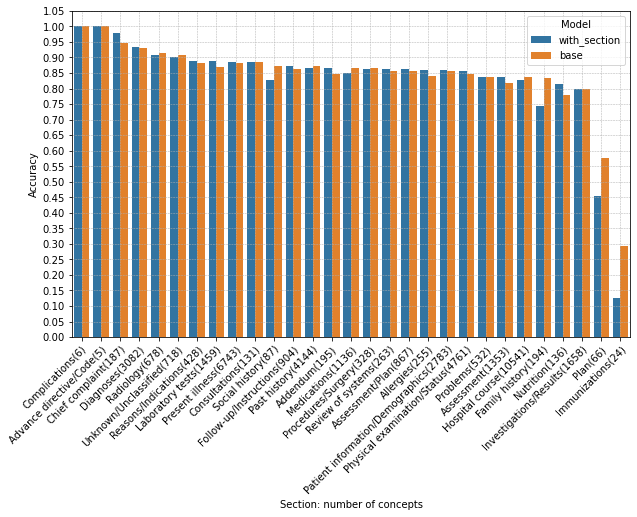

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

plt.figure(figsize=(10, 6)) 
sns.barplot(x='Section: number of concepts', y='Accuracy', hue='Model', data=plotdf, dodge=True)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.05))  # Adjust the tick spacing as needed
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  # Adjust precision as needed
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)


plt.show()

### Combining the separately trained models 

In [175]:
result_low = dfs["lowly-negated-base-adam"][["tokens"]]
result_low["lowly-negated-base-adam"] = dfs["lowly-negated-base-adam"].pred
result_low["lowly-negated-with-section-adam"] = dfs["lowly-negated-with-section-adam"].pred

<ipython-input-175-8a332eaa49fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_low["lowly-negated-base-adam"] = dfs["lowly-negated-base-adam"].pred


In [176]:
low = to_df( "/Users/chenkx/git/clinical-negation/emnlp2017-bilstm-cnn-crf/data/i2b2_2010_lowly_negated/test.txt",
                      column_names = ['token', 'begin', 'end', 'section', 'filename', 'concept', 'label', "row_id"])
low = low[["row_id","token","begin","concept","section","label"]]

In [177]:
result_low = pd.concat([low, result_low.drop("tokens", axis=1)],axis=1)
result_low

,row_id,token,begin,concept,section,label,lowly-negated-base-adam,lowly-negated-with-section-adam
0,0,The,0,O,Unknown/Unclassified,N/A,N/A,N/A
1,1,patient,4,O,Unknown/Unclassified,N/A,N/A,N/A
2,2,is,12,O,Unknown/Unclassified,N/A,N/A,N/A
3,3,a,15,O,Unknown/Unclassified,N/A,N/A,N/A
4,4,**AGE,17,O,Unknown/Unclassified,N/A,N/A,N/A
...,...,...,...,...,...,...,...,...
405625,441891,on,7673,O,Follow-up/Instructions,N/A,N/A,N/A
405626,441892,10/13/01,7676,O,Follow-up/Instructions,N/A,N/A,N/A
405627,441893,.,7685,O,Follow-up/Instructions,N/A,N/A,N/A
405628,None,\n,None,None,None,None,None,None


In [178]:
compute_acc(result_low, "label", "lowly-negated-base-adam", "present")
compute_acc(result_low, "label", "lowly-negated-with-section-adam", "present")

lowly-negated-base-adam
Percentage of tagging concept as N/A: 1987/38379=0.0518
Percentage of tagging non-concept: 10069/340222=0.0296
Concept-level accuracy (NOT relabeling NA concepts): 14101/16139=0.8737
Concept-level Percentage of tagging concept as N/A: 821/16139=0.0509
Concept-level Accracy (after converting converting N/A concepts to present): 0.9163(14788/16139)
lowly-negated-with-section-adam
Percentage of tagging concept as N/A: 3302/38379=0.0860
Percentage of tagging non-concept: 5726/340222=0.0168
Concept-level accuracy (NOT relabeling NA concepts): 13769/16139=0.8532
Concept-level Percentage of tagging concept as N/A: 1384/16139=0.0858
Concept-level Accracy (after converting converting N/A concepts to present): 0.9239(14911/16139)


[0.9288673493316657, 35649, 38379]

In [179]:
result_high

,row_id,token,begin,concept,section,label,highly-negated-base-adam,highly-negated-with-section-adam
0,2811,:,2019,O,Allergies,N/A,N/A,N/A
1,2812,BACTRIM,2021,O,Allergies,N/A,absent,absent
2,2813,.,2029,O,Allergies,N/A,N/A,N/A
3,None,\n,None,None,None,None,None,None
4,2815,MEDICATIONS,2031,O,Allergies,N/A,N/A,N/A
...,...,...,...,...,...,...,...,...
36314,441944,:,7943,O,Complications,N/A,N/A,N/A
36315,441945,10/08/01,7945,O,Complications,N/A,N/A,N/A
36316,441946,T,7954,O,Complications,N/A,N/A,N/A
36317,441947,:,7956,O,Complications,N/A,N/A,N/A


In [180]:
compute_acc(result_high, "label", "highly-negated-base-adam", "present")
compute_acc(result_high, "label", "highly-negated-with-section-adam", "present")

highly-negated-base-adam
Percentage of tagging concept as N/A: 580/5285=0.1097
Percentage of tagging non-concept: 1590/28320=0.0561
Concept-level accuracy (NOT relabeling NA concepts): 1998/2411=0.8287
Concept-level Percentage of tagging concept as N/A: 215/2411=0.0892
Concept-level Accracy (after converting converting N/A concepts to present): 0.8880(2141/2411)
highly-negated-with-section-adam
Percentage of tagging concept as N/A: 529/5285=0.1001
Percentage of tagging non-concept: 2160/28320=0.0763
Concept-level accuracy (NOT relabeling NA concepts): 2003/2411=0.8308
Concept-level Percentage of tagging concept as N/A: 214/2411=0.0888
Concept-level Accracy (after converting converting N/A concepts to present): 0.8864(2137/2411)


[0.9027436140018922, 4771, 5285]

In [181]:
result = pd.concat([result_high, result_low])
result = result[~result.row_id.isna()].sort_values(by="row_id")

In [182]:
result

,row_id,token,begin,concept,section,label,highly-negated-base-adam,highly-negated-with-section-adam,lowly-negated-base-adam,lowly-negated-with-section-adam
0,0,The,0,O,Unknown/Unclassified,N/A,NaN,NaN,N/A,N/A
1,1,patient,4,O,Unknown/Unclassified,N/A,NaN,NaN,N/A,N/A
10,10,year-old,32,O,Unknown/Unclassified,N/A,NaN,NaN,N/A,N/A
1000,1000,come,842,O,Hospital course,N/A,NaN,NaN,N/A,N/A
9427,10000,life,2390,O,Hospital course,N/A,NaN,NaN,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...
91834,99994,.,490,O,Patient information/Demographics,N/A,NaN,NaN,N/A,N/A
91836,99996,stress,492,O,Patient information/Demographics,N/A,NaN,NaN,N/A,N/A
91837,99997,test,499,O,Patient information/Demographics,N/A,NaN,NaN,N/A,N/A
91838,99998,was,504,O,Patient information/Demographics,N/A,NaN,NaN,N/A,N/A


In [183]:
result["base"] = result["highly-negated-base-adam"].combine_first(result["lowly-negated-base-adam"])
result["with-section"] = result["highly-negated-with-section-adam"].combine_first(result["lowly-negated-with-section-adam"])

In [184]:
compute_acc(result, "label","base", "present")
compute_acc(result, "label","with-section", "present")

base
Percentage of tagging concept as N/A: 2487/43664=0.0570
Percentage of tagging non-concept: 11659/368542=0.0316
Concept-level accuracy (NOT relabeling NA concepts): 16018/18550=0.8635
Concept-level Percentage of tagging concept as N/A: 1023/18550=0.0551
Concept-level Accracy (after converting converting N/A concepts to present): 0.9078(16839/18550)
with-section
Percentage of tagging concept as N/A: 3766/43664=0.0862
Percentage of tagging non-concept: 7886/368542=0.0214
Concept-level accuracy (NOT relabeling NA concepts): 15702/18550=0.8465
Concept-level Percentage of tagging concept as N/A: 1583/18550=0.0853
Concept-level Accracy (after converting converting N/A concepts to present): 0.9146(16966/18550)


[0.9175522169292781, 40064, 43664]

## Save results to csv for comparison

In [ ]:
model = "base" # "using_section"
trainset = "full" # "highly_negated", "lowly_negated", "downsample_lowly_negated", "downsample_full"
testset = "full" # "highly_negated", "lowly_negated", "downsample_lowly_negated", "downsample_full"
f"{model}-trained_and_tested_on_{}-tested_on_{}"

In [45]:
result_high

,row_id,token,begin,concept,section,label,highly-negated-base-adam,highly-negated-with-section-adam
0,2811,:,2019,O,Allergies,N/A,N/A,N/A
1,2812,BACTRIM,2021,O,Allergies,N/A,absent,absent
2,2813,.,2029,O,Allergies,N/A,N/A,N/A
3,None,\n,None,None,None,None,None,None
4,2815,MEDICATIONS,2031,O,Allergies,N/A,N/A,N/A
...,...,...,...,...,...,...,...,...
36314,441944,:,7943,O,Complications,N/A,N/A,N/A
36315,441945,10/08/01,7945,O,Complications,N/A,N/A,N/A
36316,441946,T,7954,O,Complications,N/A,N/A,N/A
36317,441947,:,7956,O,Complications,N/A,N/A,N/A


In [48]:
full[full.section.isin(highly_negated_sections)]

,row_id,token,begin,concept,section,label,base,with_section
2811,2811,:,2019,O,Allergies,N/A,N/A,N/A
2812,2812,BACTRIM,2021,O,Allergies,N/A,absent,N/A
2813,2813,.,2029,O,Allergies,N/A,N/A,N/A
2814,2814,\n,None,None,Allergies,None,None,None
2815,2815,MEDICATIONS,2031,O,Allergies,N/A,N/A,N/A
...,...,...,...,...,...,...,...,...
441945,441945,10/08/01,7945,O,Complications,N/A,N/A,N/A
441946,441946,T,7954,O,Complications,N/A,N/A,N/A
441947,441947,:,7956,O,Complications,N/A,N/A,N/A
441948,441948,10/08/01,7958,O,Complications,N/A,N/A,N/A


# Hide certain concepts 

## Load results

In [26]:
models = [m[:-4] for m in os.listdir("/Users/chenkx/git/clinical-negation/emnlp2017-bilstm-cnn-crf/results/predictions/new")]
models.sort()
models

['show-highly-negated-base',
 'show-highly-negated-with_section',
 'show-lowly-negated-base',
 'show-lowly-negated-with_section']

In [6]:
dfs = {}
for m in models:
#     if m in ["base-adam", "section-adam"]:
#         continue
    df = to_df(os.path.join("/Users/chenkx/git/clinical-negation/emnlp2017-bilstm-cnn-crf/results/predictions/new",m+".txt"),
              column_names=["tokens","pred","label"])
    dfs[m] = df

## Load raw data

In [8]:
raw = to_df(DATA_DIR)
raw["row_id"] = raw.index.to_list()
raw.section = raw.section.fillna(method="ffill")
# raw.insert(0,"row_id", raw.index.to_list())

,token,begin,end,section,filename,concept,label,row_id
0,The,0,3,Unknown/Unclassified,0003.txt,O,N/A,0
1,patient,4,11,Unknown/Unclassified,0003.txt,O,N/A,1
2,is,12,14,Unknown/Unclassified,0003.txt,O,N/A,2
3,a,15,16,Unknown/Unclassified,0003.txt,O,N/A,3
4,**AGE,17,22,Unknown/Unclassified,0003.txt,O,N/A,4
...,...,...,...,...,...,...,...,...
441945,10/08/01,7945,7953,Complications,0476.txt,O,N/A,441945
441946,T,7954,7955,Complications,0476.txt,O,N/A,441946
441947,:,7956,7957,Complications,0476.txt,O,N/A,441947
441948,10/08/01,7958,7966,Complications,0476.txt,O,N/A,441948


In [21]:
result = raw.copy()
for model in dfs:
    result[model] = dfs[model].pred

In [22]:
result

,token,begin,end,section,filename,concept,label,row_id,show-highly-negated-base,show-highly-negated-with_section,show-lowly-negated-base,show-lowly-negated-with_section
0,The,0,3,Unknown/Unclassified,0003.txt,O,N/A,0,N/A,N/A,N/A,N/A
1,patient,4,11,Unknown/Unclassified,0003.txt,O,N/A,1,N/A,N/A,N/A,N/A
2,is,12,14,Unknown/Unclassified,0003.txt,O,N/A,2,N/A,N/A,N/A,N/A
3,a,15,16,Unknown/Unclassified,0003.txt,O,N/A,3,N/A,N/A,N/A,N/A
4,**AGE,17,22,Unknown/Unclassified,0003.txt,O,N/A,4,N/A,N/A,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...
441945,10/08/01,7945,7953,Complications,0476.txt,O,N/A,441945,N/A,N/A,N/A,N/A
441946,T,7954,7955,Complications,0476.txt,O,N/A,441946,N/A,N/A,N/A,N/A
441947,:,7956,7957,Complications,0476.txt,O,N/A,441947,N/A,N/A,N/A,N/A
441948,10/08/01,7958,7966,Complications,0476.txt,O,N/A,441948,N/A,N/A,N/A,N/A


In [24]:
for model in dfs:
    compute_acc(result, "label", model)

show-highly-negated-base
Accracy: 0.0900(3929/43664)
Percentage of tagging concept as N/A: 39501/43664=0.9047
Percentage of tagging non-concept: 0/43664=0.0000
show-highly-negated-with_section
Accracy: 0.1022(4464/43664)
Percentage of tagging concept as N/A: 38880/43664=0.8904
Percentage of tagging non-concept: 0/43664=0.0000
show-lowly-negated-base
Accracy: 0.7763(33898/43664)
Percentage of tagging concept as N/A: 7289/43664=0.1669
Percentage of tagging non-concept: 0/43664=0.0000
show-lowly-negated-with_section
Accracy: 0.7770(33925/43664)
Percentage of tagging concept as N/A: 7433/43664=0.1702
Percentage of tagging non-concept: 0/43664=0.0000
